In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

(1000, 2)
               day          mag
count  1000.000000  1000.000000
mean     31.968000    17.412438
std      18.484444     1.076524
min       0.000000    15.510356
25%      15.984000    16.401527
50%      31.968000    17.226028
75%      47.952000    18.465561
max      63.936000    19.718430


Text(0.5, 1.0, 'noisy SN')

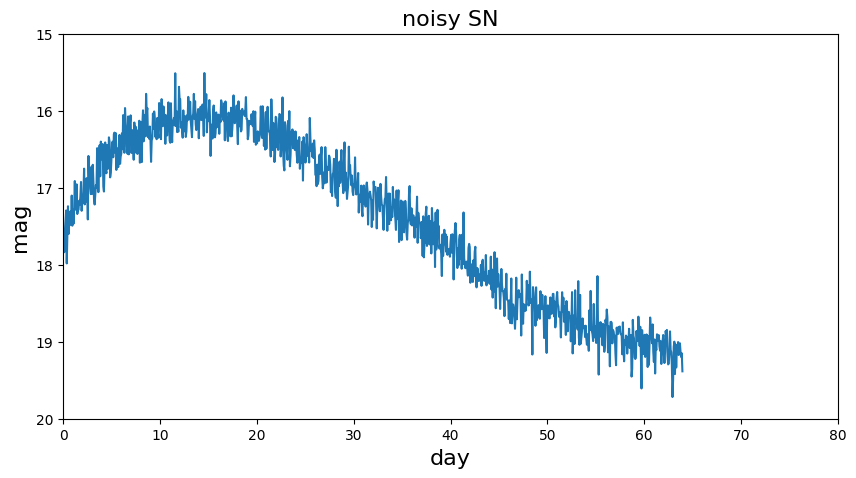

In [2]:
data = pd.read_csv('noisy_sn.dat', sep=r'\s+', names=['day','mag'])
print(data.shape)
print(data.describe())
plt.figure(figsize=(10, 5))
plt.plot(data['day'], data['mag'])
plt.xlim(0, 80)
plt.ylim(15, 20)
plt.gca().invert_yaxis()
plt.xlabel('day', fontsize=16); plt.ylabel('mag', fontsize=16); plt.title('noisy SN', fontsize=16)

In [3]:
def Gaussian_kernel(sigma, l, shift=True):
    if shift:length = np.linspace(-l // 2, l // 2, l)
    else:length = np.linspace(0, l, l)
    kernel = np.exp(-length**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    
    return kernel

def Conv_self(data, kernel):
    kernel = np.flip(kernel)
    N = len(data)
    K = len(kernel)

    data_usage = np.zeros(N + 2*(K - 1))
    data_usage[K - 1:N + K - 1] = data
    result = np.zeros(N)
    
    for _ in range(N):
        result[_] = np.sum(data_usage[_:_+K] * kernel)
    
    return result

def Conv_data(data, kernel):
    N = len(data)
    K = len(kernel)
    
    kpad = np.zeros(N)
    kpad[:K] = kernel
    
    data_ft = np.fft.fft(data)
    kernel_ft = np.fft.fft(kpad)
    result = data_ft * kernel_ft
    
    return np.fft.ifft(result).real

In [4]:
kernel_1 = Gaussian_kernel(1, 10)
kernel_2 = Gaussian_kernel(2, 10)
kernel_5 = Gaussian_kernel(5, 10)
kernel_10 = Gaussian_kernel(10, 10)

In [5]:
result_1 = Conv_data(data['mag'], kernel_1)
result_2 = Conv_data(data['mag'], kernel_2)
result_5 = Conv_data(data['mag'], kernel_5)
result_10 = Conv_data(data['mag'], kernel_10)

In [6]:
res_self_1 = Conv_self(data['mag'], kernel_1)
res_self_2 = Conv_self(data['mag'], kernel_2)
res_self_5 = Conv_self(data['mag'], kernel_5)
res_self_10 = Conv_self(data['mag'], kernel_10)

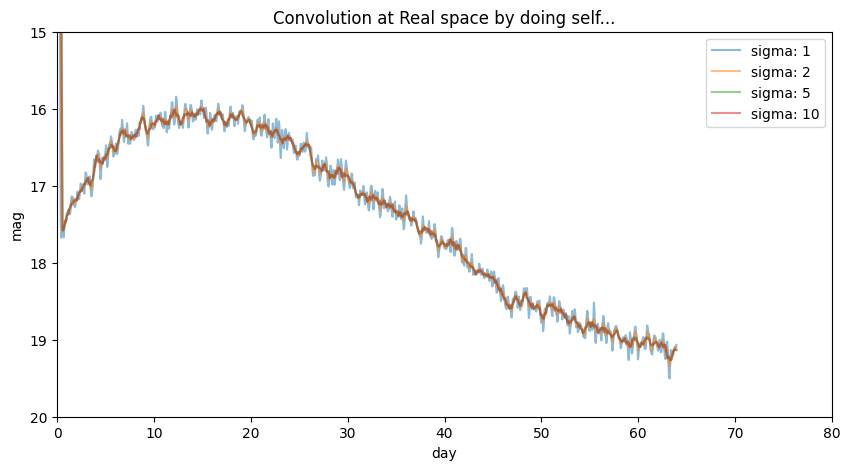

In [62]:
plt.figure(figsize=(10, 5))
plt.title("Convolution at Real space by doing self...")
plt.ylim(15, 20)
plt.xlim(0, 80)
plt.xlabel("day")
plt.ylabel("mag")
plt.gca().invert_yaxis()
plt.plot(data['day'], res_self_1, label='sigma: 1', alpha=0.5)
plt.plot(data['day'], res_self_2, label='sigma: 2', alpha=0.5)
plt.plot(data['day'], res_self_5, label='sigma: 5', alpha=0.5)
plt.plot(data['day'], res_self_10, label='sigma: 10', alpha=0.5)
plt.legend()

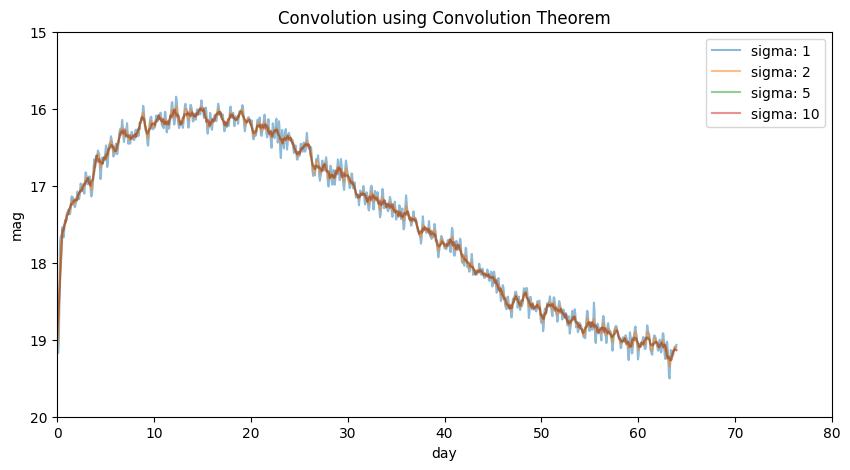

In [52]:
plt.figure(figsize=(10, 5))
plt.title("Convolution using Convolution Theorem")
plt.xlim(0, 80)
plt.ylim(15, 20)
plt.xlabel('day')
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.plot(data['day'], result_1, label='sigma: 1', alpha=0.5)
plt.plot(data['day'], result_2, label='sigma: 2', alpha=0.5)
plt.plot(data['day'], result_5, label='sigma: 5', alpha=0.5)
plt.plot(data['day'], result_10, label='sigma: 10', alpha=0.5)
plt.legend()

In [ ]:
cmp_res = np.zeros((4, 2))
list_1 = [res_self_1, res_self_2, res_self_5, res_self_10]
list_2 = [result_1, result_2, result_5, result_10]
for _ in range(4):
    cmp_res[_][0] = np.mean((list_1[_][:50] - list_2[_][:50])**2)
    cmp_res[_][1] = np.mean((list_1[_][50:] - list_2[_][50:])**2)

In [29]:
list_3 = [1, 2, 5, 10]
for i in range(4):
    print(f"MSE for 0~50 with {list_3[i]}-kernel:   {cmp_res[i][0]}")
    print(f"MSE for 50~950 with {list_3[i]}-kernel: {cmp_res[i][1]}")
    print("\n")


MSE for 0~50 with 1-kernel:   29.562888853300038
MSE for 50~950 with 1-kernel: 2.121786721074452e-29


MSE for 0~50 with 2-kernel:   25.83870820634987
MSE for 50~950 with 2-kernel: 1.752765893411065e-29


MSE for 0~50 with 5-kernel:   21.88960796841179
MSE for 50~950 with 5-kernel: 1.925152760699362e-29


MSE for 0~50 with 10-kernel:   21.16630898606313
MSE for 50~950 with 10-kernel: 2.9803995379150056e-29




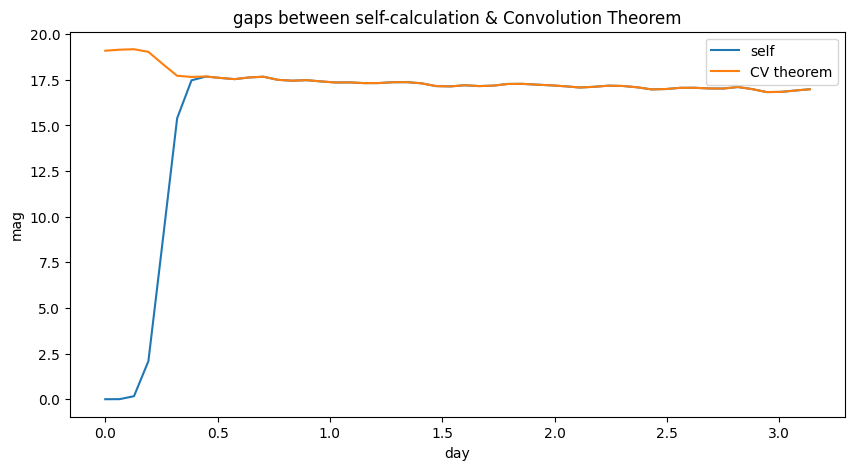

In [57]:
plt.figure(figsize=(10, 5))
plt.title("gaps between self-calculation & Convolution Theorem")
plt.xlabel("day")
plt.ylabel("mag")
plt.plot(data['day'][:50], res_self_1[:50], label="self")
plt.plot(data['day'][:50], result_1[:50], label="CV theorem")
plt.legend()

In [33]:
kernel_err = Gaussian_kernel(1, 10, False)
cmp_result_1 = Conv_data(data['mag'], kernel_err)

In [42]:
def mse(x, y):
    return np.mean((x - y)**2)

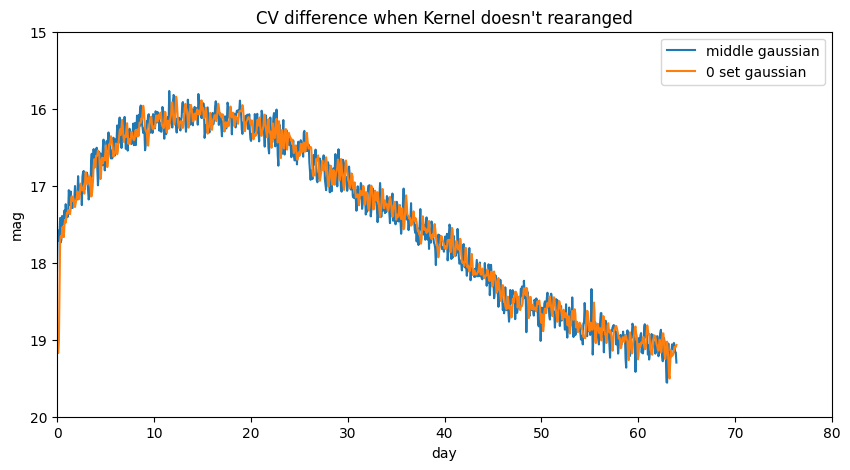

In [61]:
plt.figure(figsize=(10, 5))
plt.xlabel("day")
plt.ylabel("mag")
plt.title("CV difference when Kernel doesn't rearanged")
plt.ylim(15, 20)
plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.plot(data['day'], cmp_result_1, label="middle gaussian")
plt.plot(data['day'], result_1, label="0 set gaussian")
plt.legend()

In [45]:
mse_1 = mse(data['mag'], result_1)
mse_2 = mse(data['mag'], cmp_result_1)

print(f"When kernel zero fit  : {mse_1}")
print(f"When kernel middle fit: {mse_2}")

When kernel zero fit  : 0.05964511167972209
When kernel middle fit: 0.010533763330329009
